<a href="https://colab.research.google.com/github/arvizu-god/oqs/blob/main/qecc/qec_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals of Quantum Error Correction (QEC)

In this notebook I present the qiskit version of the basic quantum error correction codes, as presented in *Nielsen, Chuang - Quantum Computation and Quantum Information* and *Nakahara, Ohmi - Quantum Computing: From Linear Algebra to Physical Realizations*.

The following qec schemes are included:


*   Three qubit bit flip code
*   Three qubit phase flip code
*   Shor Code



In [57]:
!pip install qiskit qiskit-aer pylatexenc

In [58]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.result import marginal_counts
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, QuantumError
from qiskit.visualization import plot_histogram
#from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

#service=QiskitRuntimeService()

In [ ]:
def bit_flip_qecc():
    #Initialize quantum and classical registers for initial qubits and syndrome qubits
    qreg_data=QuantumRegister(3,'qubits') #Initial 3 qubit register
    qreg_measure=QuantumRegister(2,'ancillas') #Syndrome qubits register
    creg_data=ClassicalRegister(3,'data') #Classical register for measurement of original 3 qubits
    creg_syndrome=ClassicalRegister(2,'syndrome') #Classical register for measurement of syndrome qubits
    state_data=qreg_data[0] #Variable that stores the initial state of encoded qubit
    ancillas_data=qreg_data[:1] #Variable that stores the first two ancilla qubits that encode the original qubit

    #Prepare quantum circuit
    qc=QuantumCircuit(qreg_data,qreg_measure,creg_data,creg_syndrome)
    qc.h(qreg_data[0]) #Initial qubit in superposition state
    qc.barrier(qreg_data)

    #Encoding the qubit
    qc.cx(qreg_data[0],qreg_data[1]) #Apply cx to initial superposition gate and first ancilla qubit
    qc.cx(qreg_data[0],qreg_data[2])
    qc.barrier(qreg_data)

    #Adding bit-flip error to qreg_data[1]
    qc.x(qreg_data[2]) #Simulate bit flip error on first ancilla qubit
    qc.barrier()

    #Syndrome detection
    qc.cx(qreg_data[0],qreg_measure[0])
    qc.cx(qreg_data[1],qreg_measure[0])
    qc.cx(qreg_data[0],qreg_measure[1])
    qc.cx(qreg_data[2],qreg_measure[1])
    qc.barrier(*qreg_data,*qreg_measure)
    qc.measure(qreg_measure,creg_syndrome)

    #if_test instructions are used for resetting the syndrome ancilla qubits to their initial |0> state after measurement
    with qc.if_test((creg_syndrome[0],1)):
        qc.x(qreg_measure[0])
    with qc.if_test((creg_syndrome[1],1)):
        qc.x(qreg_measure[1])
    qc.barrier(*qreg_data,*qreg_measure)

    #Error correction
    with qc.if_test((creg_syndrome,3)):
        qc.x(qreg_data[0])
    with qc.if_test((creg_syndrome,2)):
        qc.x(qreg_data[1])
    with qc.if_test((creg_syndrome,1)):
        qc.x(qreg_data[2])
    qc.barrier(*qreg_data,*qreg_measure)

    #Decoding
    qc.cx(qreg_data[0],qreg_data[2])
    qc.cx(qreg_data[0],qreg_data[1])
    qc.h(qreg_data[0])
    qc.barrier()

    #Measurement
    qc.measure(qreg_data[0],creg_data[0])

    return qc

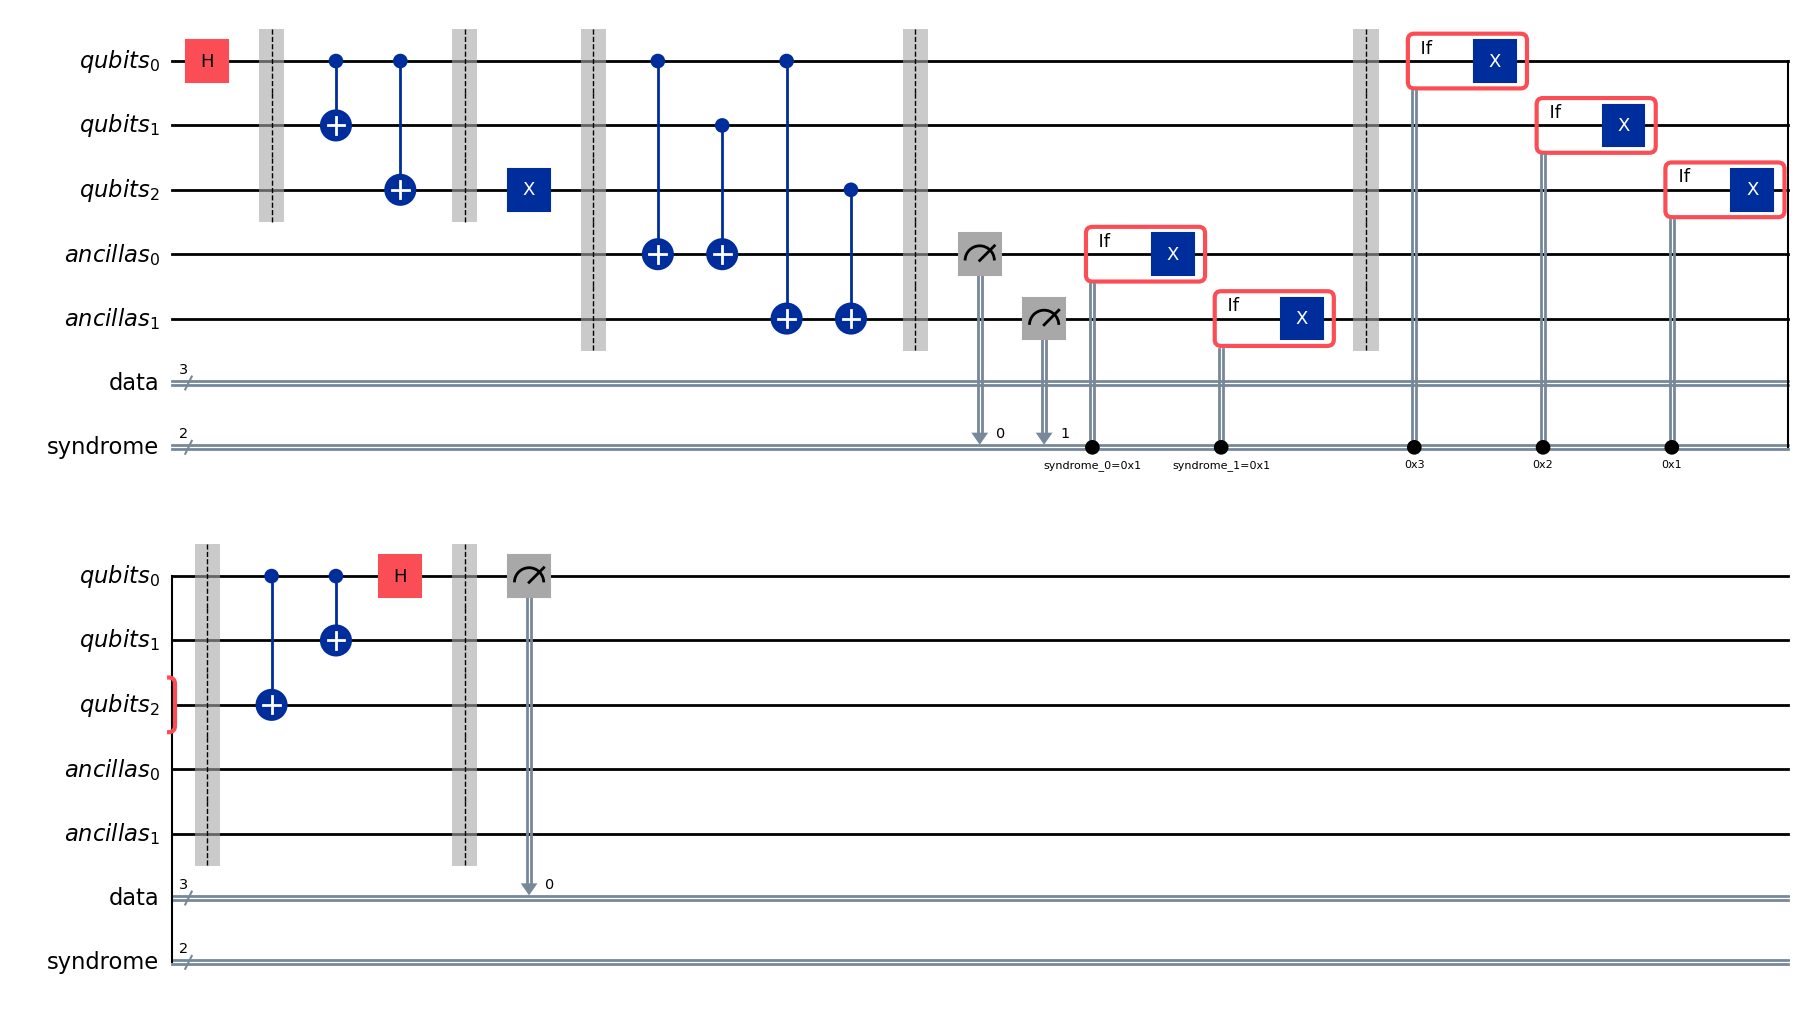

In [ ]:
bf_qc=bit_flip_qecc()
bf_qc.draw(output='mpl',style='iqp')

Counts:  {'10 000': 1024}


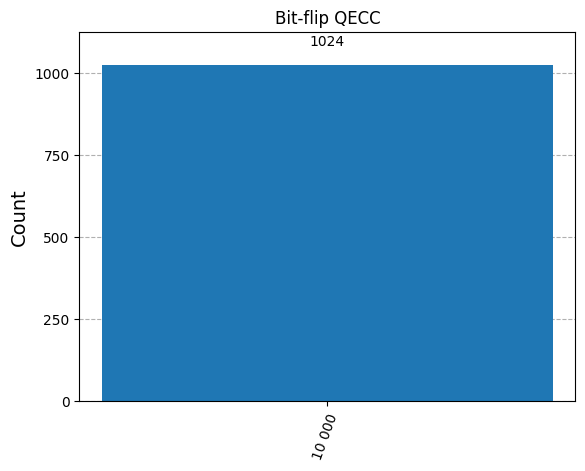

In [ ]:
bf_qc1=bf_qc.copy()
simulator=AerSimulator()
bf_tqc1=transpile(bf_qc1,simulator)
job=simulator.run(bf_tqc1,shots=1024)
result=job.result()
counts=result.get_counts()
print('Counts: ',counts)
plot_histogram(counts,title='Bit-flip QECC')

In [ ]:
def phase_flip_qecc():
    #Initialize quantum and classical registers for initial qubits and syndrome qubits
    qreg_data=QuantumRegister(3,'qubits') #Initial 3 qubit register
    qreg_measure=QuantumRegister(2,'ancillas') #Syndrome qubits register
    creg_data=ClassicalRegister(3,'data') #Classical register for measurement of original 3 qubits
    creg_syndrome=ClassicalRegister(2,'syndrome') #Classical register for measurement of syndrome qubits
    state_data=qreg_data[0] #Variable that stores the initial state of encoded qubit
    ancillas_data=qreg_data[:1] #Variable that stores the first two ancilla qubits that encode the original qubit

    #Prepare quantum circuit
    qc=QuantumCircuit(qreg_data,qreg_measure,creg_data,creg_syndrome)
    qc.h(qreg_data[0]) #Initial qubit in superposition state
    #qc.h(qreg_data[1])
    #qc.h(qreg_data[2])
    qc.barrier(qreg_data)

    #Encoding the qubit
    qc.cx(qreg_data[0],qreg_data[1]) #Apply cx to initial superposition gate and first ancilla qubit
    qc.cx(qreg_data[0],qreg_data[2])
    qc.h(qreg_data[0])
    qc.h(qreg_data[1])
    qc.h(qreg_data[2])
    qc.barrier(qreg_data)

    #Adding bit-flip error to qreg_data[1]
    qc.z(qreg_data[1]) #Simulate phase flip error on first ancilla qubit
    qc.barrier()

    #Syndrome detection
    qc.h(qreg_data[0])
    qc.h(qreg_data[1])
    qc.h(qreg_data[2])
    qc.cx(qreg_data[0],qreg_measure[0])
    qc.cx(qreg_data[1],qreg_measure[0])
    qc.cx(qreg_data[0],qreg_measure[1])
    qc.cx(qreg_data[2],qreg_measure[1])
    qc.barrier(*qreg_data,*qreg_measure)
    qc.measure(qreg_measure,creg_syndrome)

    #if_test instructions are used for resetting the syndrome ancilla qubits to their initial |0> state after measurement
    with qc.if_test((creg_syndrome[0],1)):
        qc.x(qreg_measure[0])
    with qc.if_test((creg_syndrome[1],1)):
        qc.x(qreg_measure[1])
    qc.barrier(*qreg_data,*qreg_measure)

    #Error correction
    with qc.if_test((creg_syndrome,3)):
        qc.x(qreg_data[0])
    with qc.if_test((creg_syndrome,2)):
        qc.x(qreg_data[1])
    with qc.if_test((creg_syndrome,1)):
        qc.x(qreg_data[2])
    qc.barrier(*qreg_data,*qreg_measure)

    #Decoding
    #qc.h(qreg_data[0])
    #qc.h(qreg_data[1])
    #qc.h(qreg_data[2])
    qc.cx(qreg_data[0],qreg_data[2])
    qc.cx(qreg_data[0],qreg_data[1])
    qc.h(qreg_data[0])
    qc.barrier()

    #Measurement
    qc.measure(qreg_data[0],creg_data[0])

    return qc

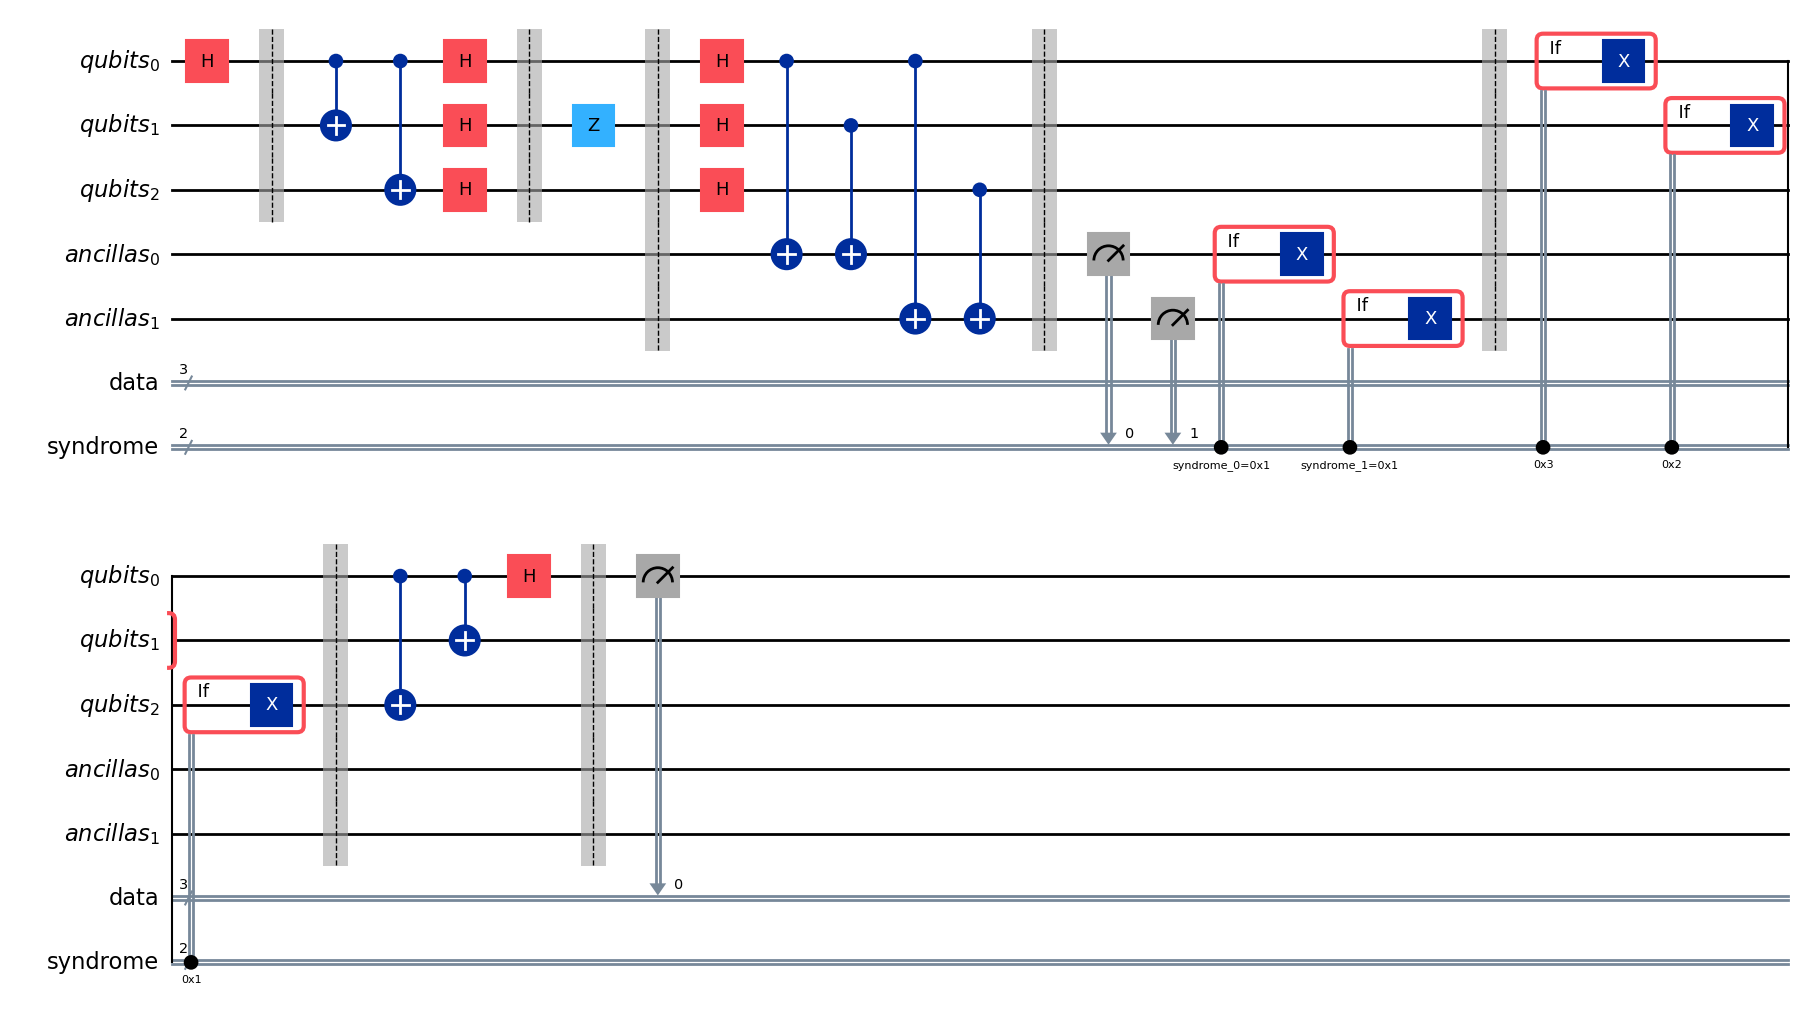

In [ ]:
pf_qc=phase_flip_qecc()
pf_qc.draw(output='mpl',style='iqp')

Counts:  {'01 000': 1024}


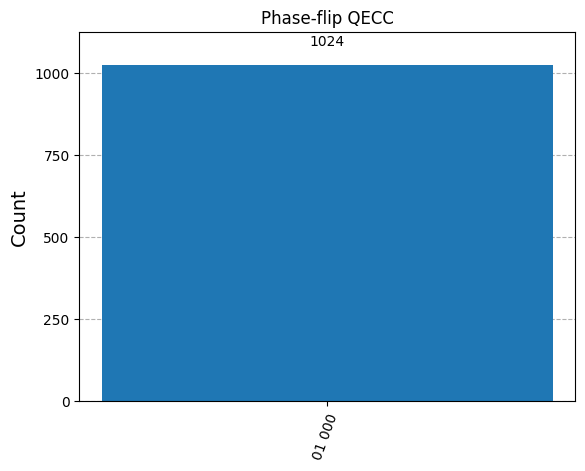

In [ ]:
pf_qc1=pf_qc.copy()
simulator=AerSimulator()
pf_tqc1=transpile(pf_qc1,simulator)
job=simulator.run(pf_tqc1,shots=1024)
result=job.result()
counts=result.get_counts()
print('Counts: ',counts)
plot_histogram(counts,title='Phase-flip QECC')

In [ ]:
def shor_nine_qecc():
    #Initialize quantum and classical registers for initial qubits and syndrome qubits
    qreg_data=QuantumRegister(3,'qubits') #Initial 3 qubit register
    qreg_measure=QuantumRegister(2,'ancillas') #Syndrome qubits register
    creg_data=ClassicalRegister(3,'data') #Classical register for measurement of original 3 qubits
    creg_syndrome=ClassicalRegister(2,'syndrome') #Classical register for measurement of syndrome qubits
    state_data=qreg_data[0] #Variable that stores the initial state of encoded qubit
    ancillas_data=qreg_data[:1] #Variable that stores the first two ancilla qubits that encode the original qubit

    #Prepare quantum circuit
    qc=QuantumCircuit(qreg_data,creg_data)
    qc.h(qreg_data[0]) #Initial qubit in superposition state
    #qc.h(qreg_data[1])
    #qc.h(qreg_data[2])
    qc.barrier(qreg_data)

    #Encoding the qubit
    qc.cx(qreg_data[0],qreg_data[5]) #Apply cx to initial superposition gate and first ancilla qubit
    qc.cx(qreg_data[0],qreg_data[10])
    qc.h(qreg_data[0])
    qc.h(qreg_data[5])
    qc.h(qreg_data[10])
    qc.cx(qreg_data[0],qreg_data[1])
    qc.cx(qreg_data[0],qreg_data[2])
    qc.cx(qreg_data[5],qreg_data[6])
    qc.cx(qreg_data[5],qreg_data[7])
    qc.cx(qreg_data[10],qreg_data[11])
    qc.cx(qreg_data[10],qreg_data[12])
    qc.barrier(qreg_data)

    #Adding bit-flip error to qreg_data[1]
    qc.z(qreg_data[10]) #Simulate phase flip error on first ancilla qubit
    qc.x(qreg_data[5])
    qc.barrier()

    #Bit-flip syndrome detection
    qc.cx(qreg_data[0],qreg_data[3])
    qc.cx(qreg_data[1],qreg_data[3])
    qc.cx(qreg_data[0],qreg_data[4])
    qc.cx(qreg_data[3],qreg_data[4])
    qc.barrier(*qreg_data,*qreg_measure)
    qc.measure(qreg_measure,creg_syndrome)

    #Bit-flip error correction


    #Phase-flip syndrome detection
    qc.h(qreg_data[0])
    qc.h(qreg_data[1])
    qc.h(qreg_data[2])


    #Phase-flip error correction

    #if_test instructions are used for resetting the syndrome ancilla qubits to their initial |0> state after measurement
    with qc.if_test((creg_syndrome[0],1)):
        qc.x(qreg_measure[0])
    with qc.if_test((creg_syndrome[1],1)):
        qc.x(qreg_measure[1])
    qc.barrier(*qreg_data,*qreg_measure)

    #Error correction
    with qc.if_test((creg_syndrome,3)):
        qc.x(qreg_data[0])
    with qc.if_test((creg_syndrome,2)):
        qc.x(qreg_data[1])
    with qc.if_test((creg_syndrome,1)):
        qc.x(qreg_data[2])
    qc.barrier(*qreg_data,*qreg_measure)

    #Decoding
    #qc.h(qreg_data[0])
    #qc.h(qreg_data[1])
    #qc.h(qreg_data[2])
    qc.cx(qreg_data[0],qreg_data[2])
    qc.cx(qreg_data[0],qreg_data[1])
    qc.h(qreg_data[0])
    qc.barrier()

    #Measurement
    qc.measure(qreg_data[0],creg_data[0])

    return qc

In [ ]:
#initiating quantum and classical registers
qreg_q = QuantumRegister(15, 'q')
creg_c = ClassicalRegister(3, 'c')

#initiating circuit
circuit = QuantumCircuit(qreg_q, creg_c)

#encoding the circuit
circuit.x(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[5])
circuit.cx(qreg_q[0], qreg_q[10])

#adding hadamard gates for superposition to generate |+> and |-> states (for phase flip error detection)
circuit.h(qreg_q[0])
circuit.h(qreg_q[5])
circuit.h(qreg_q[10])

circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[5], qreg_q[6])
circuit.cx(qreg_q[10], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[7])
circuit.cx(qreg_q[10], qreg_q[12])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.barrier()

#simulating flip error
#circuit.z(qreg_q[10])
#circuit.x(qreg_q[10])
#circuit.barrier()

#phase-flip error detection circuit
circuit.cx(qreg_q[0], qreg_q[3])
circuit.cx(qreg_q[5], qreg_q[8])
circuit.cx(qreg_q[10], qreg_q[13])

circuit.cx(qreg_q[11], qreg_q[13])
circuit.cx(qreg_q[6], qreg_q[8])
circuit.cx(qreg_q[1], qreg_q[3])

circuit.cx(qreg_q[11], qreg_q[14])
circuit.cx(qreg_q[6], qreg_q[9])
circuit.cx(qreg_q[1], qreg_q[4])
circuit.cx(qreg_q[12], qreg_q[14])
circuit.cx(qreg_q[7], qreg_q[9])
circuit.cx(qreg_q[2], qreg_q[4])

#recovery circuit for phase-flip
circuit.barrier()
circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[10])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[5])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[0])

circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[11])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[6])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[1])

circuit.ccx(qreg_q[14], qreg_q[13], qreg_q[12])
circuit.ccx(qreg_q[9], qreg_q[8], qreg_q[7])
circuit.ccx(qreg_q[4], qreg_q[3], qreg_q[2])

#bit-flip error detection circuit
circuit.barrier()
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[5], qreg_q[7])
circuit.cx(qreg_q[10], qreg_q[12])

circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[5], qreg_q[6])
circuit.cx(qreg_q[10], qreg_q[11])

circuit.h(qreg_q[0])
circuit.h(qreg_q[5])
circuit.h(qreg_q[10])
circuit.cx(qreg_q[0], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[11])
circuit.cx(qreg_q[5], qreg_q[12])
circuit.cx(qreg_q[10], qreg_q[12])


#recovery circuit for bit-flip
circuit.barrier()
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[5])
circuit.x(qreg_q[12])
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[0])
circuit.x(qreg_q[12])
circuit.x(qreg_q[11])
circuit.ccx(qreg_q[12], qreg_q[11], qreg_q[10])
circuit.x(qreg_q[11])
circuit.cx(qreg_q[0], qreg_q[10])
circuit.cx(qreg_q[0], qreg_q[5])


#measurement
circuit.barrier()
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[5], creg_c[1])
circuit.measure(qreg_q[10], creg_c[2])

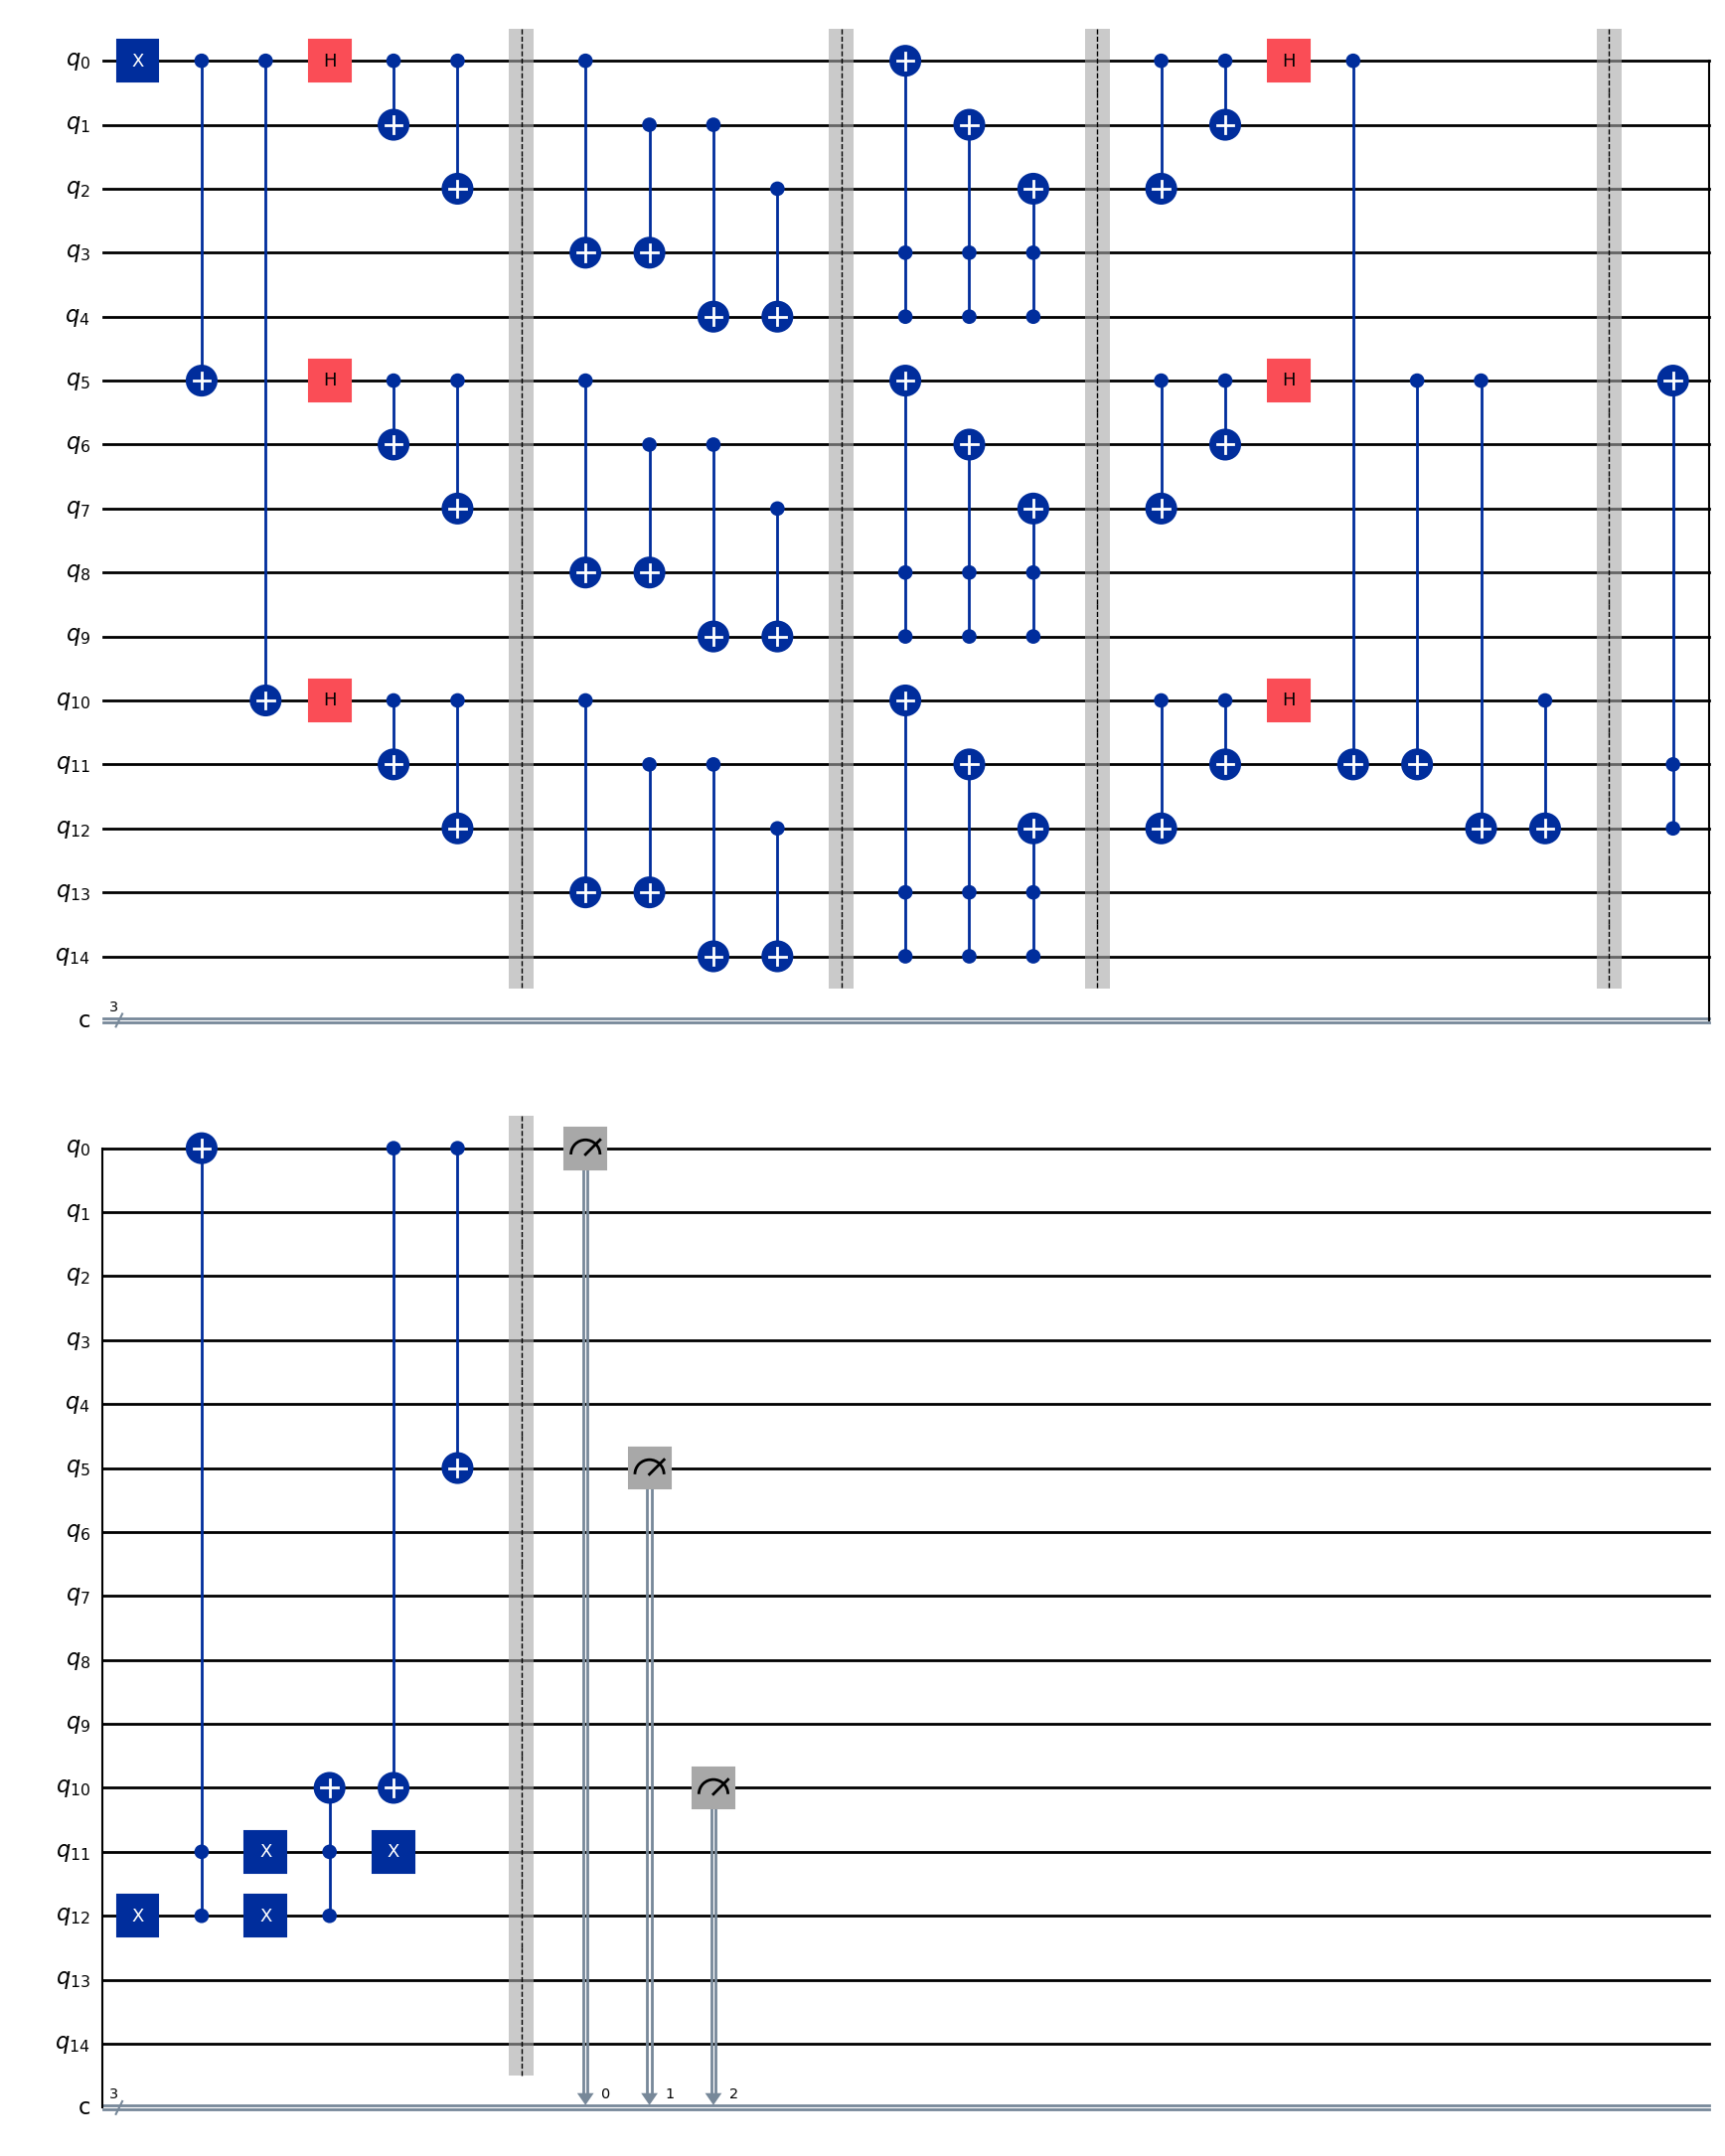

In [ ]:
circuit.draw(output='mpl',style='iqp')

Counts:  {'001': 1024}


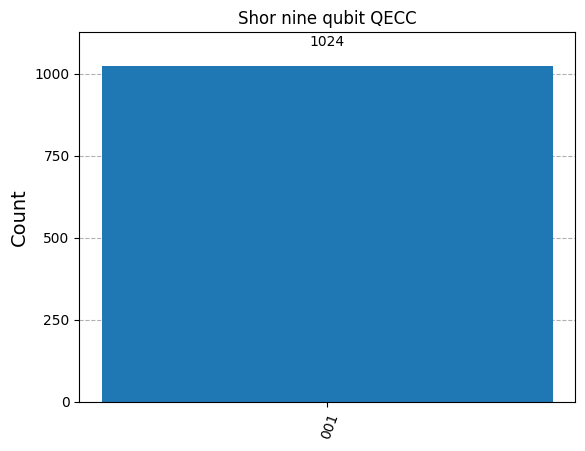

In [ ]:
snq_qc1=circuit.copy()
simulator=AerSimulator()
snq_tqc1=transpile(snq_qc1,simulator)
job=simulator.run(snq_tqc1,shots=1024)
result=job.result()
counts=result.get_counts()
print('Counts: ',counts)
plot_histogram(counts,title='Shor nine qubit QECC')